In [5]:
!pip install  pywavelets

In [15]:
!curl  "https://fastly.picsum.photos/id/8/450/300.jpg?blur=2&grayscale&hmac=IEZDiL9LH2TRFgvxHeG7-QHEAvzp_nN1Sai9YYkIweY" --output 300.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10698  100 10698    0     0  69142      0 --:--:-- --:--:-- --:--:-- 69467


In [6]:
import torch

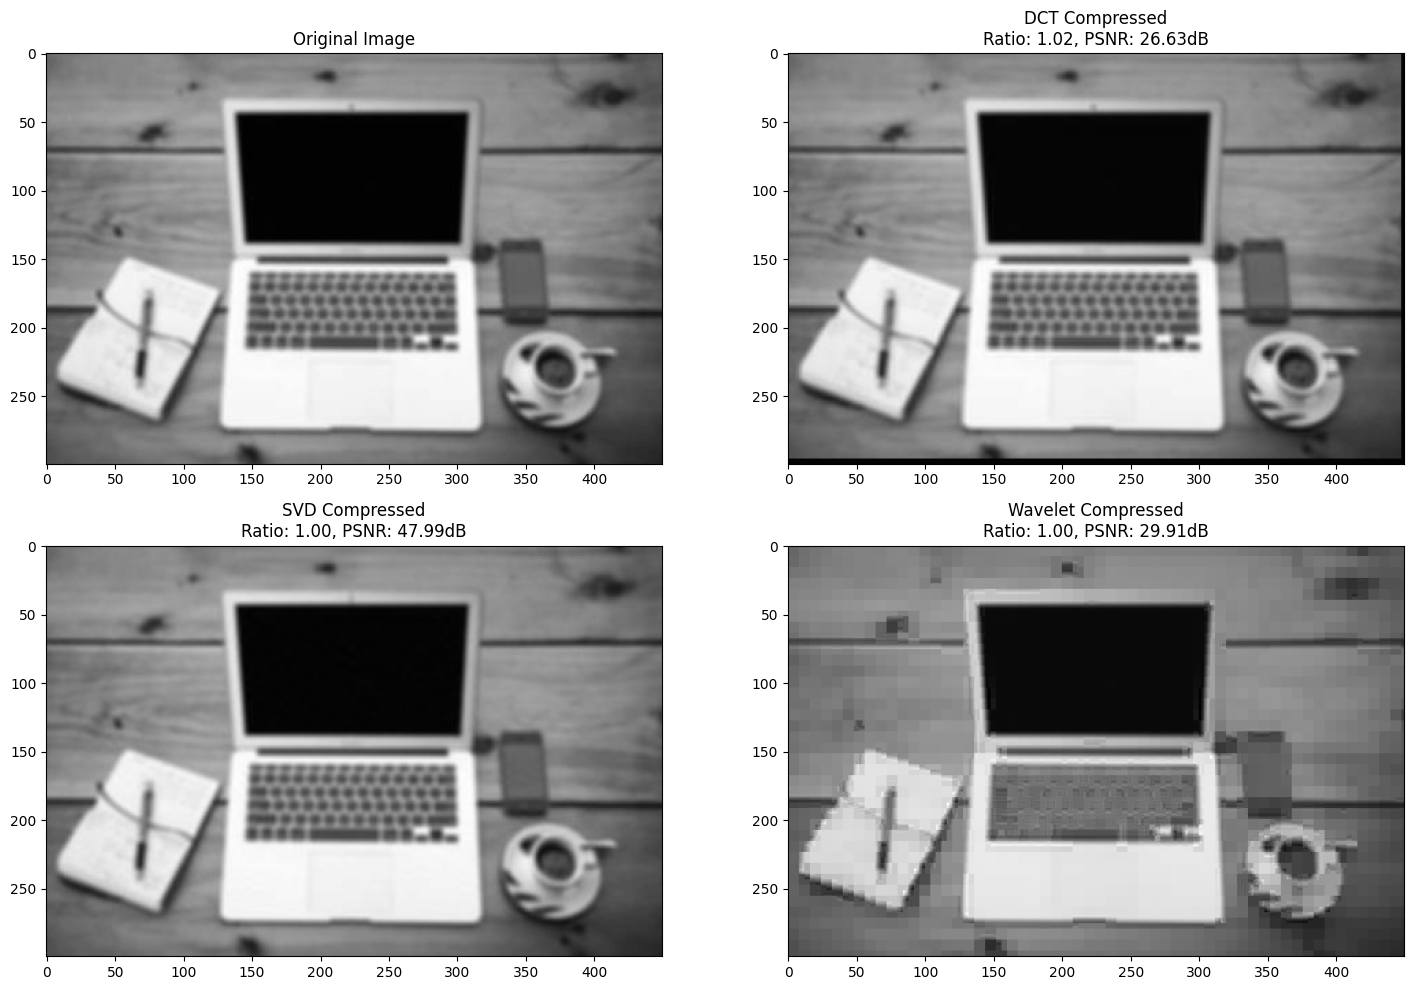

In [16]:
import numpy as np
import cv2
from scipy.fftpack import dct, idct
from scipy.linalg import svd
import pywt
import matplotlib.pyplot as plt

class ImageCompression:
    def __init__(self, image_path=None):
        """Initialize with either a path to image or use default"""
        if image_path:
            self.original = cv2.imread(image_path, 0)  # Read as grayscale
        else:
            # Create sample image if no path provided
            self.original = np.zeros((512, 512))
            cv2.circle(self.original, (256, 256), 100, 255, -1)

        self.original = self.original.astype(np.float64)

    def dct_compression(self, quality):
        """DCT-based compression similar to JPEG

        Args:
            quality (int): Number of DCT coefficients to keep (1-8)
        """
        rows, cols = self.original.shape
        compressed = np.zeros_like(self.original)

        # Process 8x8 blocks
        for i in range(0, rows, 8):
            for j in range(0, cols, 8):
                # Extract block
                block = self.original[i:i+8, j:j+8]
                if block.shape != (8, 8):  # Handle edge cases
                    continue

                # Apply DCT
                dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')

                # Zero out high frequencies
                mask = np.zeros((8, 8))
                mask[:quality, :quality] = 1
                dct_block = dct_block * mask

                # Inverse DCT
                compressed[i:i+8, j:j+8] = idct(idct(dct_block.T, norm='ortho').T, norm='ortho')

        return compressed

    def svd_compression(self, k):
        """SVD-based compression

        Args:
            k (int): Number of singular values to keep
        """
        U, s, Vt = svd(self.original, full_matrices=False)

        # Keep only k singular values
        compressed = U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]

        return compressed

    def wavelet_compression(self, threshold_percent=10):
        """Wavelet-based compression

        Args:
            threshold_percent (float): Percentage of coefficients to keep
        """
        # Perform wavelet decomposition
        coeffs = pywt.wavedec2(self.original, 'haar', level=3)

        # Threshold the coefficients
        for i in range(len(coeffs)):
            if i == 0:  # Skip approximation coefficients
                continue

            for j in range(len(coeffs[i])):
                coeff = coeffs[i][j]
                threshold = np.percentile(np.abs(coeff), 100 - threshold_percent)
                coeffs[i] = tuple(np.where(np.abs(c) >= threshold, c, 0) for c in coeffs[i])

        # Reconstruct the image
        compressed = pywt.waverec2(coeffs, 'haar')

        return compressed

    def calculate_metrics(self, compressed):
        """Calculate compression ratio and PSNR

        Args:
            compressed (np.ndarray): Compressed image
        """
        # Calculate compression ratio
        orig_size = self.original.size
        comp_size = np.count_nonzero(compressed)
        ratio = orig_size / max(comp_size, 1)  # Avoid division by zero

        # Calculate PSNR
        mse = np.mean((self.original - compressed) ** 2)
        if mse == 0:
            psnr = float('inf')
        else:
            psnr = 20 * np.log10(255 / np.sqrt(mse))

        return ratio, psnr

    def display_results(self, dct_img, svd_img, wavelet_img):
        """Display original and compressed images with metrics"""
        plt.figure(figsize=(15, 10))

        # Original image
        plt.subplot(2, 2, 1)
        plt.imshow(self.original, cmap='gray')
        plt.title('Original Image')

        # DCT compression
        plt.subplot(2, 2, 2)
        plt.imshow(dct_img, cmap='gray')
        ratio, psnr = self.calculate_metrics(dct_img)
        plt.title(f'DCT Compressed\nRatio: {ratio:.2f}, PSNR: {psnr:.2f}dB')

        # SVD compression
        plt.subplot(2, 2, 3)
        plt.imshow(svd_img, cmap='gray')
        ratio, psnr = self.calculate_metrics(svd_img)
        plt.title(f'SVD Compressed\nRatio: {ratio:.2f}, PSNR: {psnr:.2f}dB')

        # Wavelet compression
        plt.subplot(2, 2, 4)
        plt.imshow(wavelet_img, cmap='gray')
        ratio, psnr = self.calculate_metrics(wavelet_img)
        plt.title(f'Wavelet Compressed\nRatio: {ratio:.2f}, PSNR: {psnr:.2f}dB')

        plt.tight_layout()
        plt.show()

# Example usage
def main():
    # Initialize compressor with image
    image_path = "/content/300.jpg"
    compressor = ImageCompression(image_path=image_path)  # Use default image, or provide path

    # Perform compressions
    dct_compressed = compressor.dct_compression(quality=4)
    svd_compressed = compressor.svd_compression(k=50)
    wavelet_compressed = compressor.wavelet_compression(threshold_percent=10)

    # Display results
    compressor.display_results(dct_compressed, svd_compressed, wavelet_compressed)

if __name__ == "__main__":
    main()